In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK
import math
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X_train = taiwanese_bankruptcy_prediction.data.features
y_train = taiwanese_bankruptcy_prediction.data.targets

# metadata
print(taiwanese_bankruptcy_prediction.metadata)

# variable information
print(taiwanese_bankruptcy_prediction.variables)


{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
# División en conjuntos de entrenamiento, validación y prueba
size_val = math.ceil(0.1 * X_train.shape[0])
size_test = math.ceil(0.1 * X_train.shape[0])

X_train_red, X_test, y_train_red, y_test = train_test_split(X_train, y_train, test_size=size_test, random_state=1234)
X_train_red, X_val, y_train_red, y_val = train_test_split(X_train_red, y_train_red, test_size=size_val, random_state=2345)

N_TREES = 500

In [ ]:
# Definición de la función objetivo para Hyperopt
def objective(params):
    tree = DecisionTreeClassifier(**params, random_state=2345)
    tree.fit(X_train_red, y_train_red)
    y_preds_val_prob = tree.predict_proba(X_val)[:, tree.classes_ == True]
    score = roc_auc_score(y_val, y_preds_val_prob)
    return {'loss': -1 * score, 'status': STATUS_OK}

In [ ]:
# Espacio de búsqueda para los hiperparámetros
space = {'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
         'splitter': hp.choice('splitter', ['best', 'random']),
         'max_depth': hp.uniformint('max_depth', 3, 30),
         'min_samples_split': hp.uniformint('min_samples_split', 2, 20),
         'min_samples_leaf': hp.uniformint('min_samples_leaf', 1, 20),
         'min_impurity_decrease': hp.uniform('min_impurity_decrease', 0, 0.1)}

In [ ]:
# Búsqueda de hiperparámetros óptimos con Hyperopt
best = fmin(objective, space,
            algo=tpe.suggest,
            max_evals=N_TREES,
            rstate=np.random.default_rng(3456)) # best loss: -0.9341888236458402
best_tree_params = space_eval(space, best)

100%|██████████| 500/500 [01:44<00:00,  4.80trial/s, best loss: -0.9341888236458402]


In [ ]:
# Creación y entrenamiento del mejor árbol
best_tree = DecisionTreeClassifier(**best_tree_params, random_state=4567)
best_tree.fit(pd.concat([X_train_red, X_val], axis=0),
              pd.concat([y_train_red, y_val], axis=0))

# Predicción y evaluación del mejor árbol en el conjunto de test
preds_test_tree = best_tree.predict_proba(X_test)[:, best_tree.classes_ == True]
print("ROC AUC Score - Best Tree:", roc_auc_score(y_test, preds_test_tree)) # 0.8807096451774113

ROC AUC Score - Best Tree: 0.8807096451774113


In [ ]:
# Entrenamiento y evaluación del modelo Bagging
base_model = DecisionTreeClassifier()
bag = BaggingClassifier(base_model, n_estimators=N_TREES, n_jobs=-1, random_state=5678, verbose=1)
bag.fit(pd.concat([X_train_red, X_val], axis=0),
        pd.concat([y_train_red, y_val], axis=0))
preds_test_bag = bag.predict_proba(X_test)[:, bag.classes_ == True]
print("ROC AUC Score - Bagging:", roc_auc_score(y_test, preds_test_bag)) # 0.967016491754123

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_bagging.py:878: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  4.4min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC Score - Bagging: 0.967016491754123


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


In [ ]:
# Entrenamiento y evaluación del modelo Random Forest
rf = RandomForestClassifier(n_estimators=N_TREES, n_jobs=-1, random_state=6789, verbose=1, oob_score=True)
rf.fit(pd.concat([X_train_red, X_val], axis=0),
       pd.concat([y_train_red, y_val], axis=0))
preds_test_rf = rf.predict_proba(X_test)[:, rf.classes_ == True]
print("ROC AUC Score - Random Forest:", roc_auc_score(y_test, preds_test_rf)) #  0.9665667166416791

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.3s finished


ROC AUC Score - Random Forest: 0.9665667166416791


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.1s finished


In [ ]:
# Performance oob
preds_oob_rf = rf.oob_decision_function_[:, rf.classes_ == True]
print("OOB ROC AUC Score - Random Forest:", roc_auc_score(pd.concat([y_train_red, y_val]), preds_oob_rf)) # 0.9299549364340576

OOB ROC AUC Score - Random Forest: 0.9299549364340576


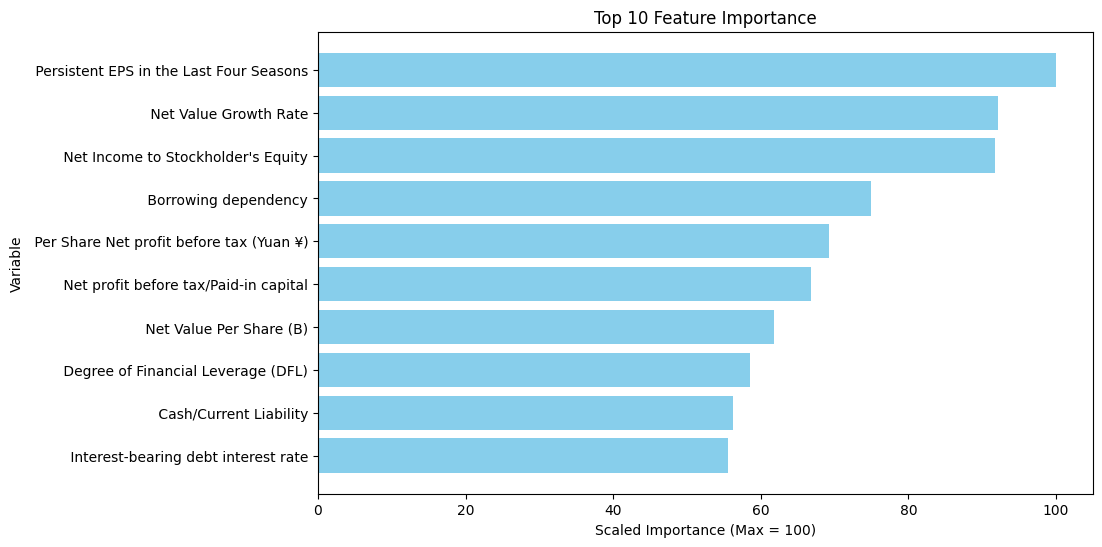

In [ ]:
# Importancia de atributos con random forest
def plot_importance(model, n_vars):
    # Sort the DataFrame by 'Importance' column in descending order
    imp_df = pd.DataFrame({"Variable": model.feature_names_in_, "Importance": model.feature_importances_})
    imp_df = imp_df.sort_values(by='Importance', ascending=False)

    # Take only the top 10 rows
    top_imp_df = imp_df.head(n_vars).copy()

    # Scale the importance values to have the max as 100
    max_importance = top_imp_df['Importance'].max()
    top_imp_df['Scaled_Importance'] = (top_imp_df['Importance'] / max_importance) * 100

    # Create the horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_imp_df['Variable'], top_imp_df['Scaled_Importance'], color='skyblue')
    plt.xlabel('Scaled Importance (Max = 100)')
    plt.ylabel('Variable')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

plot_importance(rf, 10)